In [1]:
import matplotlib.pyplot as plt

# pyqubo imports
from pyqubo import Binary, Array

#myqlm imports
from qat.plugins import ScipyMinimizePlugin
from qat.qpus import get_default_qpu
from qat.core import Observable, Term

import networkx as nx

/home/omp/anaconda3/envs/QML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


É possível verificar que o conjunto dos vértices $|V_c| = \{0,1,2,3\} $ formam um clique de tamanho $K=4$, pois formam um grafo completo. 

### Exercício 1:

Vamos codificar o grafo da figura anterior e desenhá-lo usando a framework `Networkx`.

# Problema do K-Clique

O Problema do K-Clique consiste em encontrar um subgrafo completo, $\hat{G}$, composto por $K$ vértices (nós), em um dado grafo $G(V,E)$. Um grafo é completo quando todos os seus vértices nós interconectados. Na figura abaixo, podemos ver um grafo e seu respectivo clique de tamanho $K=4$.

<img src="imagens/grafo_clique.png" width=750 />



Graph with 5 nodes and 8 edges


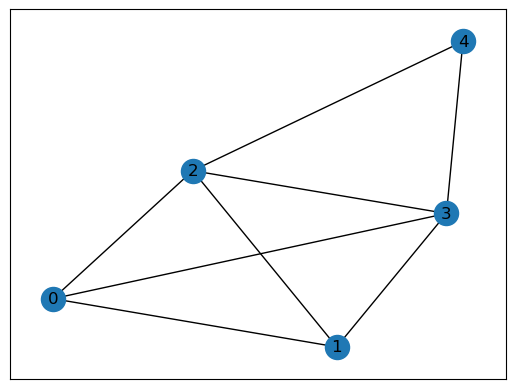

In [2]:
# Crie uma estrutura que codifique o grafo
G = nx.Graph()

# Crie uma lista com os indices de cada nó
nodes = [i for i in range(5)]

# Crie uma lista de tuplas com os nos vizinhos: g=[..., (ni,nj),...]
e = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3),(2,4),(3,4)]

G.add_nodes_from(nodes)
G.add_edges_from(e)
nx.draw_networkx(G, with_labels=True)
print(G)

### Exercício 2:

Agora, defina os parâmetros do problema. Note que queremos encontrar um clique de tamanho $K=4$ no grafo dado como exemplo.

In [3]:
# Defina o tamanho do clique
K= 4

# Numero de nos do grafo
num_nodes = len(nodes)

print(f"Tamanho do Clique: {K}\nNúmero de nós: {num_nodes}")


Tamanho do Clique: 4
Número de nós: 5


## Formulação como Otimização Irrestrita

Formularemos o problema como uma função de otimização com variáveis binárias, $x_i \in \{0,1\}$, sendo que o "estado" de cada vértice é dado por $x_i$. Se $x_i = 1$, indica que o vértice de índice $i$ faz parte do clique. A solução do exemplo com o grafo apresentado anteriormente é dada por $\vec{x} = 11110$, visto que apenas o vértice $4$ não faz parte do clique.

Apresentaremos dois termos de penalidades necessários para escrever o Problema do Clique como Otimização Irrestrita. Um dos termos está relacionado ao fato de que o número de vértices no estado $x_i = 1$ deve ser igual a $K$. Para isso, criamos o termo

$$ H_a = \left(K - \sum_{i=0}^{N}x_i\right)^2. $$

Quanto maior a diferença entre $K$ e o número de vértices em estado $1$, maior será a penalidade na função objetivo. O valor de $H_a$ será $0$ (mínimo) quando o critério for atendido. 

### Exercício 3a:

Escreva o termo $H_a$ da função objetivo em termos das variáveis binárias `Binary('xi')` do Pyqubo.

In [4]:
# Criando o termo Ha
variables = Array.create('x', shape=num_nodes, vartype='BINARY')
x_sum = sum(variables) 

Ha = (K - x_sum)**2
Ha

((4.000000 + (-1.000000 * (Binary('x[4]') + Binary('x[3]') + Binary('x[2]') + Binary('x[1]') + 0.000000 + Binary('x[0]')))) * (4.000000 + (-1.000000 * (Binary('x[4]') + Binary('x[3]') + Binary('x[2]') + Binary('x[1]') + 0.000000 + Binary('x[0]')))))

Contudo, claramente, essa condição não é suficiente para garantir que o clique seja encontrado. Para isso, introduziremos outros conceitos, começando pela quantidade de arestas em um clique. Essa quantidade é dada por

$$E = \frac{K(K-1)}{2}.$$

Logo, introduziremos um novo termo na função objetivo, cujo papel desempenhado é o de penalizar a função caso o número de arestas do subgrafo que conectam os nós de estado $x_i = 1$ seja diferente de $E$. Queremos que a quantidade de arestas do clique seja igual a $E$, logo, criamos o seguinte termo:

$$H_b = E - \sum_{<ij>}x_ix_j$$
onde $<ij>$ representa os índices apenas dos vértices conectados entre si. 

### Exercício 3b:

Escreva o termo $H_b$ da função objetivo em termos das variáveis binárias `Binary('xi')` do Pyqubo.

In [5]:
# Criando o termo Hb

# Numero de arestas no clique
E = K*(K-1)//2

quadratic_terms_sum = sum([variables[edge[0]]*variables[edge[1]] for edge in e])

Hb = E - quadratic_terms_sum
Hb
print(f"Número de arestas no Clique: {E}")

Número de arestas no Clique: 6


Introduziremos ainda as variáveis de penalidade dadas por $A$ e $B$, que são números inteiros usados para controlar a função objetivo e garantir que as restrições serão atendidas. Sendo assim, a função objetivo final é dada por 

$$H = A\left(K - \sum_{i=0}^{N}x_i\right)^2 + B\left( C - \sum_{<ij>}x_ix_j\right).$$

Neste problema, devemos considerar as constantes de penalidade satisfaznedo $A > B$.

### Exercício 3c:

Escreva a função objetivo inteira juntando os termos $H_a$ e $H_b$ com suas variáveis de penalidade.

In [6]:
# Penalidades para Ha e Hb
A = 4
B = 1
print(f"Constantes de penalidade: {A} e {B}.")

Hamil = A*Ha + B*Hb

model = Hamil.compile()
qubo = model.to_qubo()
print(qubo)

Constantes de penalidade: 4 e 1.
({('x[4]', 'x[0]'): 8.0, ('x[0]', 'x[0]'): -28.0, ('x[3]', 'x[1]'): 7.0, ('x[3]', 'x[0]'): 7.0, ('x[4]', 'x[4]'): -28.0, ('x[4]', 'x[2]'): 7.0, ('x[4]', 'x[1]'): 8.0, ('x[4]', 'x[3]'): 7.0, ('x[3]', 'x[2]'): 7.0, ('x[3]', 'x[3]'): -28.0, ('x[2]', 'x[2]'): -28.0, ('x[1]', 'x[1]'): -28.0, ('x[2]', 'x[1]'): 7.0, ('x[1]', 'x[0]'): 7.0, ('x[2]', 'x[0]'): 7.0}, 70.0)


### QLM Problem Generator

In [7]:
from qat.generators import KCliqueGenerator

scipy_args = dict(method="COBYLA", tol=1e-5, options={"maxiter": 200})
kclique_application = KCliqueGenerator(job_type="qaoa") | (ScipyMinimizePlugin(**scipy_args) | get_default_qpu())

In [8]:
combinatorial_result = kclique_application.execute(G, K, A, B)
print("The nodes of the complete subgraph are", combinatorial_result.clique)
print(combinatorial_result.cost)

/tmp/ipykernel_20948/4075100051.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  combinatorial_result = kclique_application.execute(G, K, A, B)


The nodes of the complete subgraph are [0, 1, 2, 3]
-70.0


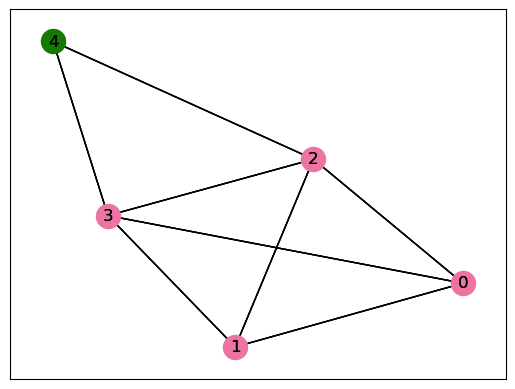

In [9]:
combinatorial_result.display()

In [10]:
single_values = {}
multiple_values = {}
for k,v in qubo[0].items():
    if k[0] == k[1]:
        single_values[int(k[0][2])] = v
    else:
        multiple_values[(int(k[0][2]), int(k[1][2]))] = v

num_qubits = num_nodes
hamiltonian_clique = Observable(num_qubits,
                           pauli_terms=
                           [Term(single_values[x], "Z", [x]) for x in single_values]+
                           [Term(multiple_values[x], "ZZ", [x[0],x[1]]) for x in multiple_values],
                           constant_coeff=qubo[1]
                           )

print(hamiltonian_clique)

70.0 * I^5 +
-28.0 * (Z|[0]) +
-28.0 * (Z|[4]) +
-28.0 * (Z|[3]) +
-28.0 * (Z|[2]) +
-28.0 * (Z|[1]) +
8.0 * (ZZ|[4, 0]) +
7.0 * (ZZ|[3, 1]) +
7.0 * (ZZ|[3, 0]) +
7.0 * (ZZ|[4, 2]) +
8.0 * (ZZ|[4, 1]) +
7.0 * (ZZ|[4, 3]) +
7.0 * (ZZ|[3, 2]) +
7.0 * (ZZ|[2, 1]) +
7.0 * (ZZ|[1, 0]) +
7.0 * (ZZ|[2, 0])


# Problema do Max Cut

Para um grafo, um corte máximo é um corte cujo tamanho é de pelo menos o tamanho de qualquer outro corte. O problema de encontrar um corte máximo em um grafo é conhecido como Problema do Corte-Máximo (Max-Cut).

O problema pode ser descrito simplesmente como segue. Deseja-se um subconjunto S do conjunto de vértices tal que o número de arestas entre S e o subconjunto complementar é tão grande quanto possível.

![MaxCut](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Max-cut.svg/200px-Max-cut.svg.png)

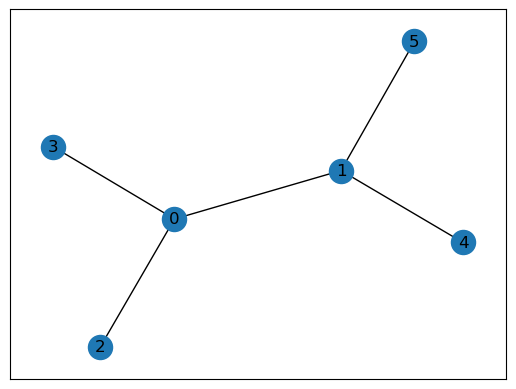

In [11]:
graph = nx.full_rary_tree(3, 6)
nx.draw_networkx(graph)

In [12]:
from qat.generators import MaxCutGenerator

scipy_args = dict(method="COBYLA", tol=1e-5, options={"maxiter": 200})
max_cut_application = MaxCutGenerator(job_type="qaoa") | (ScipyMinimizePlugin(**scipy_args) | get_default_qpu())

In [13]:
combinatorial_result = max_cut_application.execute(graph)
print("The nodes in the first subgraph are", combinatorial_result.subsets[0])
print("The nodes in the second subgraph are", combinatorial_result.subsets[1])
# The cost here is negative since all combinatorial optimization problems are defined as a minimization problem, so a factor of -1 is needed
print("The number of edges that are cut is", -1 * combinatorial_result.cost)

/tmp/ipykernel_20948/2872952381.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  combinatorial_result = max_cut_application.execute(graph)


The nodes in the first subgraph are [0, 4, 5]
The nodes in the second subgraph are [1, 2, 3]
The number of edges that are cut is 5.0


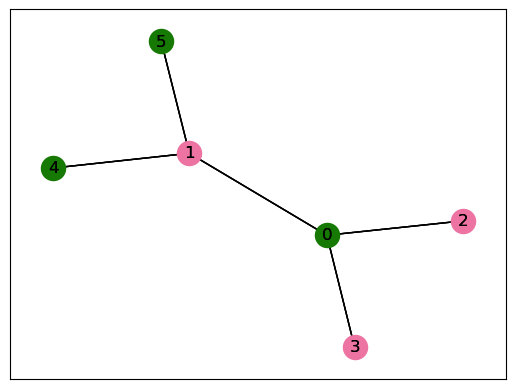

In [14]:
combinatorial_result.display()

Atualmente QLM só possui disponível os ```Problem Generators``` dos problemas abaixo:

 - Max Cut
 - Vertex Cover
 - Graph Partitioning
 - Graph Colouring
 - K-clique